<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/DatasetAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import ast

# Accessing the Dataset via Kaggle API
To access this dataset, I downloaded a .json token from the dataset link - https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k as shown below:

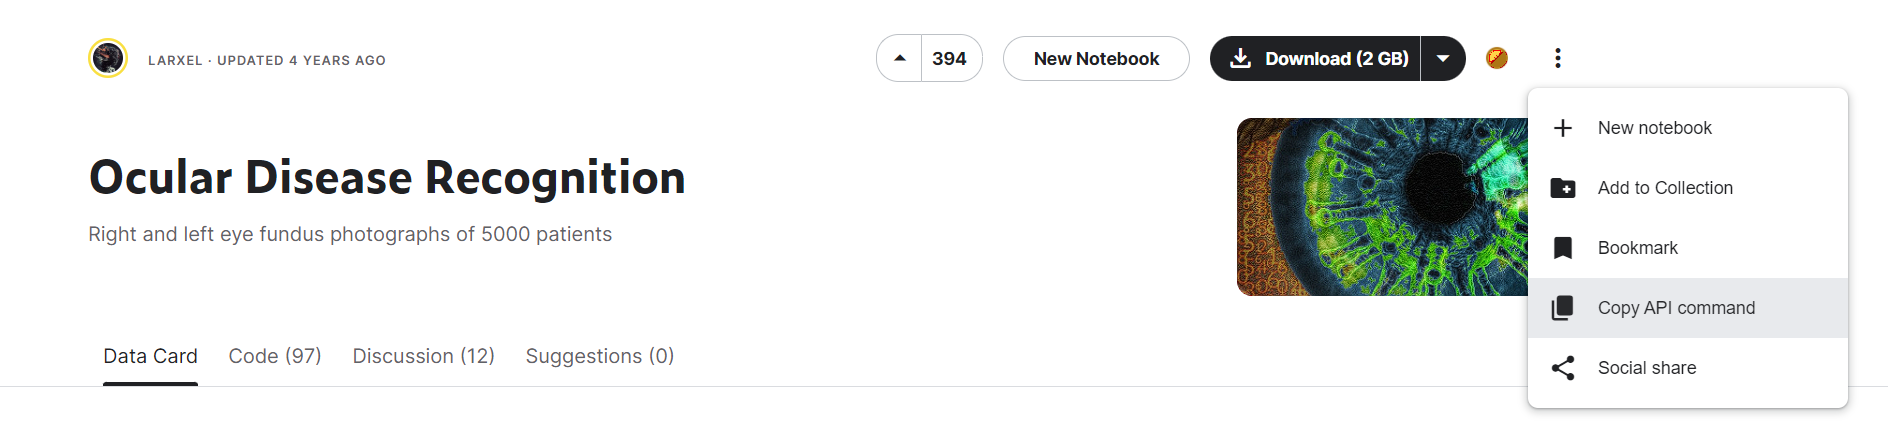

Then installed the Kaggle API client, which allowed to upload the token to colab and the API downlaoded the dataset and unzipped it for use in colab.

In [2]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
100% 1.62G/1.62G [00:16<00:00, 161MB/s]
100% 1.62G/1.62G [00:16<00:00, 105MB/s]


# Loading the Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a one hot encoded equivalent representation.

- For the Labels, of the image decided to directly use the one-hot encoded target column since its suitable for a multi-class classifcation problem, for a muliti-label classification problem, the individually encoded columns per class could be used after conversion into a binary vector.

- All 8 condition are used, - Normal, Diabetes, Glaucoma, Cataract, Age

In [4]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Dataset Information

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [7]:
class_distribution = df_data['labels'].value_counts()
print("Class Distribution (Count):\n", class_distribution)

Class Distribution (Count):
 labels
['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: count, dtype: int64


## Class Distribution
-  There is class imbalance, with the majority classes being Normal, and Diabetes. The minority classes are Glaucoma, Cataract, AMD, Hypertension and Myopia.
- Techniques to combat this class imbalance will be applied such as random sampling, data augmentation and class weights.

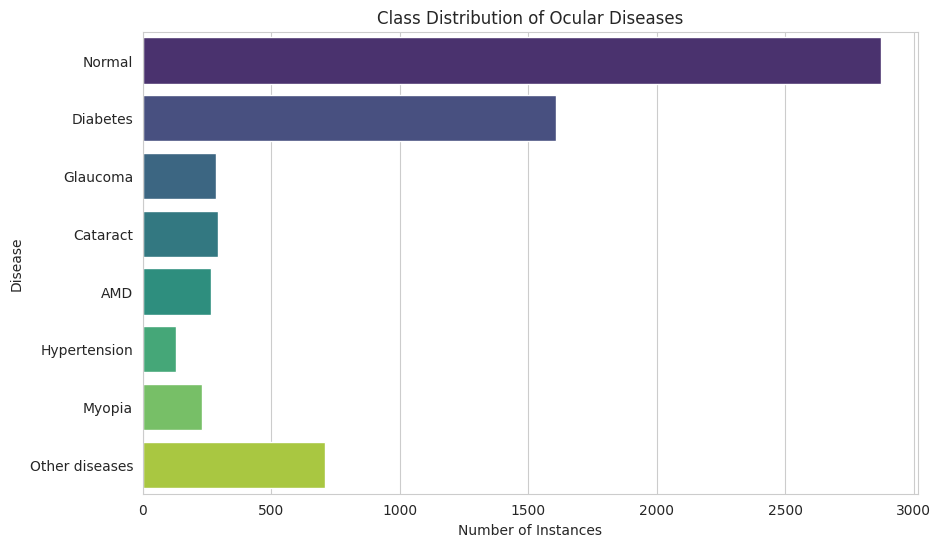

In [ ]:
# Define the class labels as provided by the user
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
df_data['class_name'] = df_data['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = df_data['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the class distribution using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.values, y=class_counts.index, hue=class_counts.index, palette="viridis", legend=False)
plt.title('Class Distribution of Ocular Diseases')
plt.xlabel('Number of Instances')
plt.ylabel('Disease')
plt.show()


## Patient Age and Sex Frequency
- From these graphs, the fundus images come from patients aged 20-80 with patients with 60 having a higher frequency.
- Futhermore, patient sex is mostly balanced, but slightly dominated by males.

<ipython-input-9-eaded22def01>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Patient Sex', data=df_data, ax=axes[1], palette='pastel')


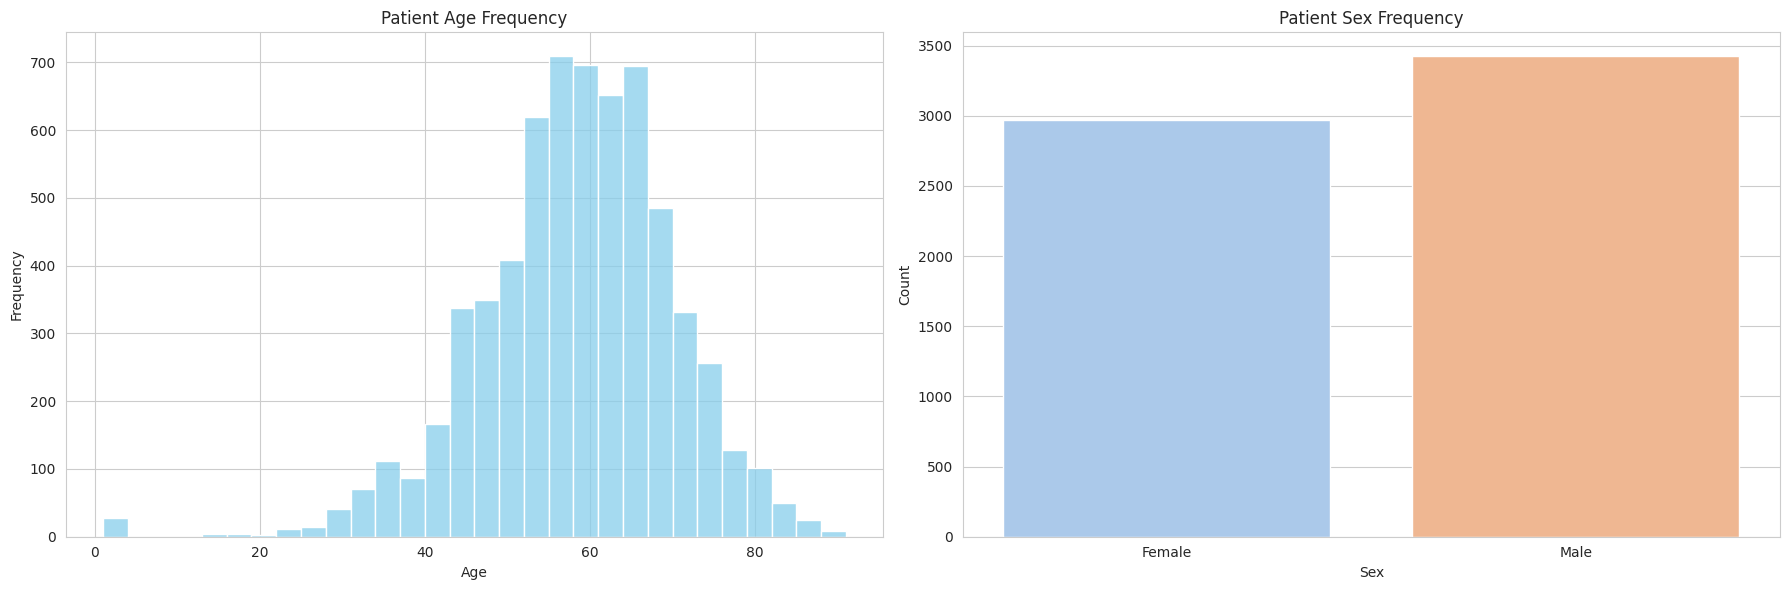

In [ ]:
# Set the aesthetics for the plots
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the Patient Age Frequency distribution
sns.histplot(df_data['Patient Age'], bins=30, ax=axes[0], kde=False, color='skyblue')
axes[0].set_title('Patient Age Frequency')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plotting the Patient Sex Frequency distribution
sns.countplot(x='Patient Sex', data=df_data, ax=axes[1], palette='pastel')
axes[1].set_title('Patient Sex Frequency')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Count')

# Show the plots
plt.tight_layout()
plt.show()

## Age and Sex Distribution for Each Condition:

- The histograms show the frequency of patient ages for each specific condition. The bar charts illustrate the count of male and female patients for each condition.
- In both scenarios, hypertension is the lowest and females have a higher frequency for majority of dieases.

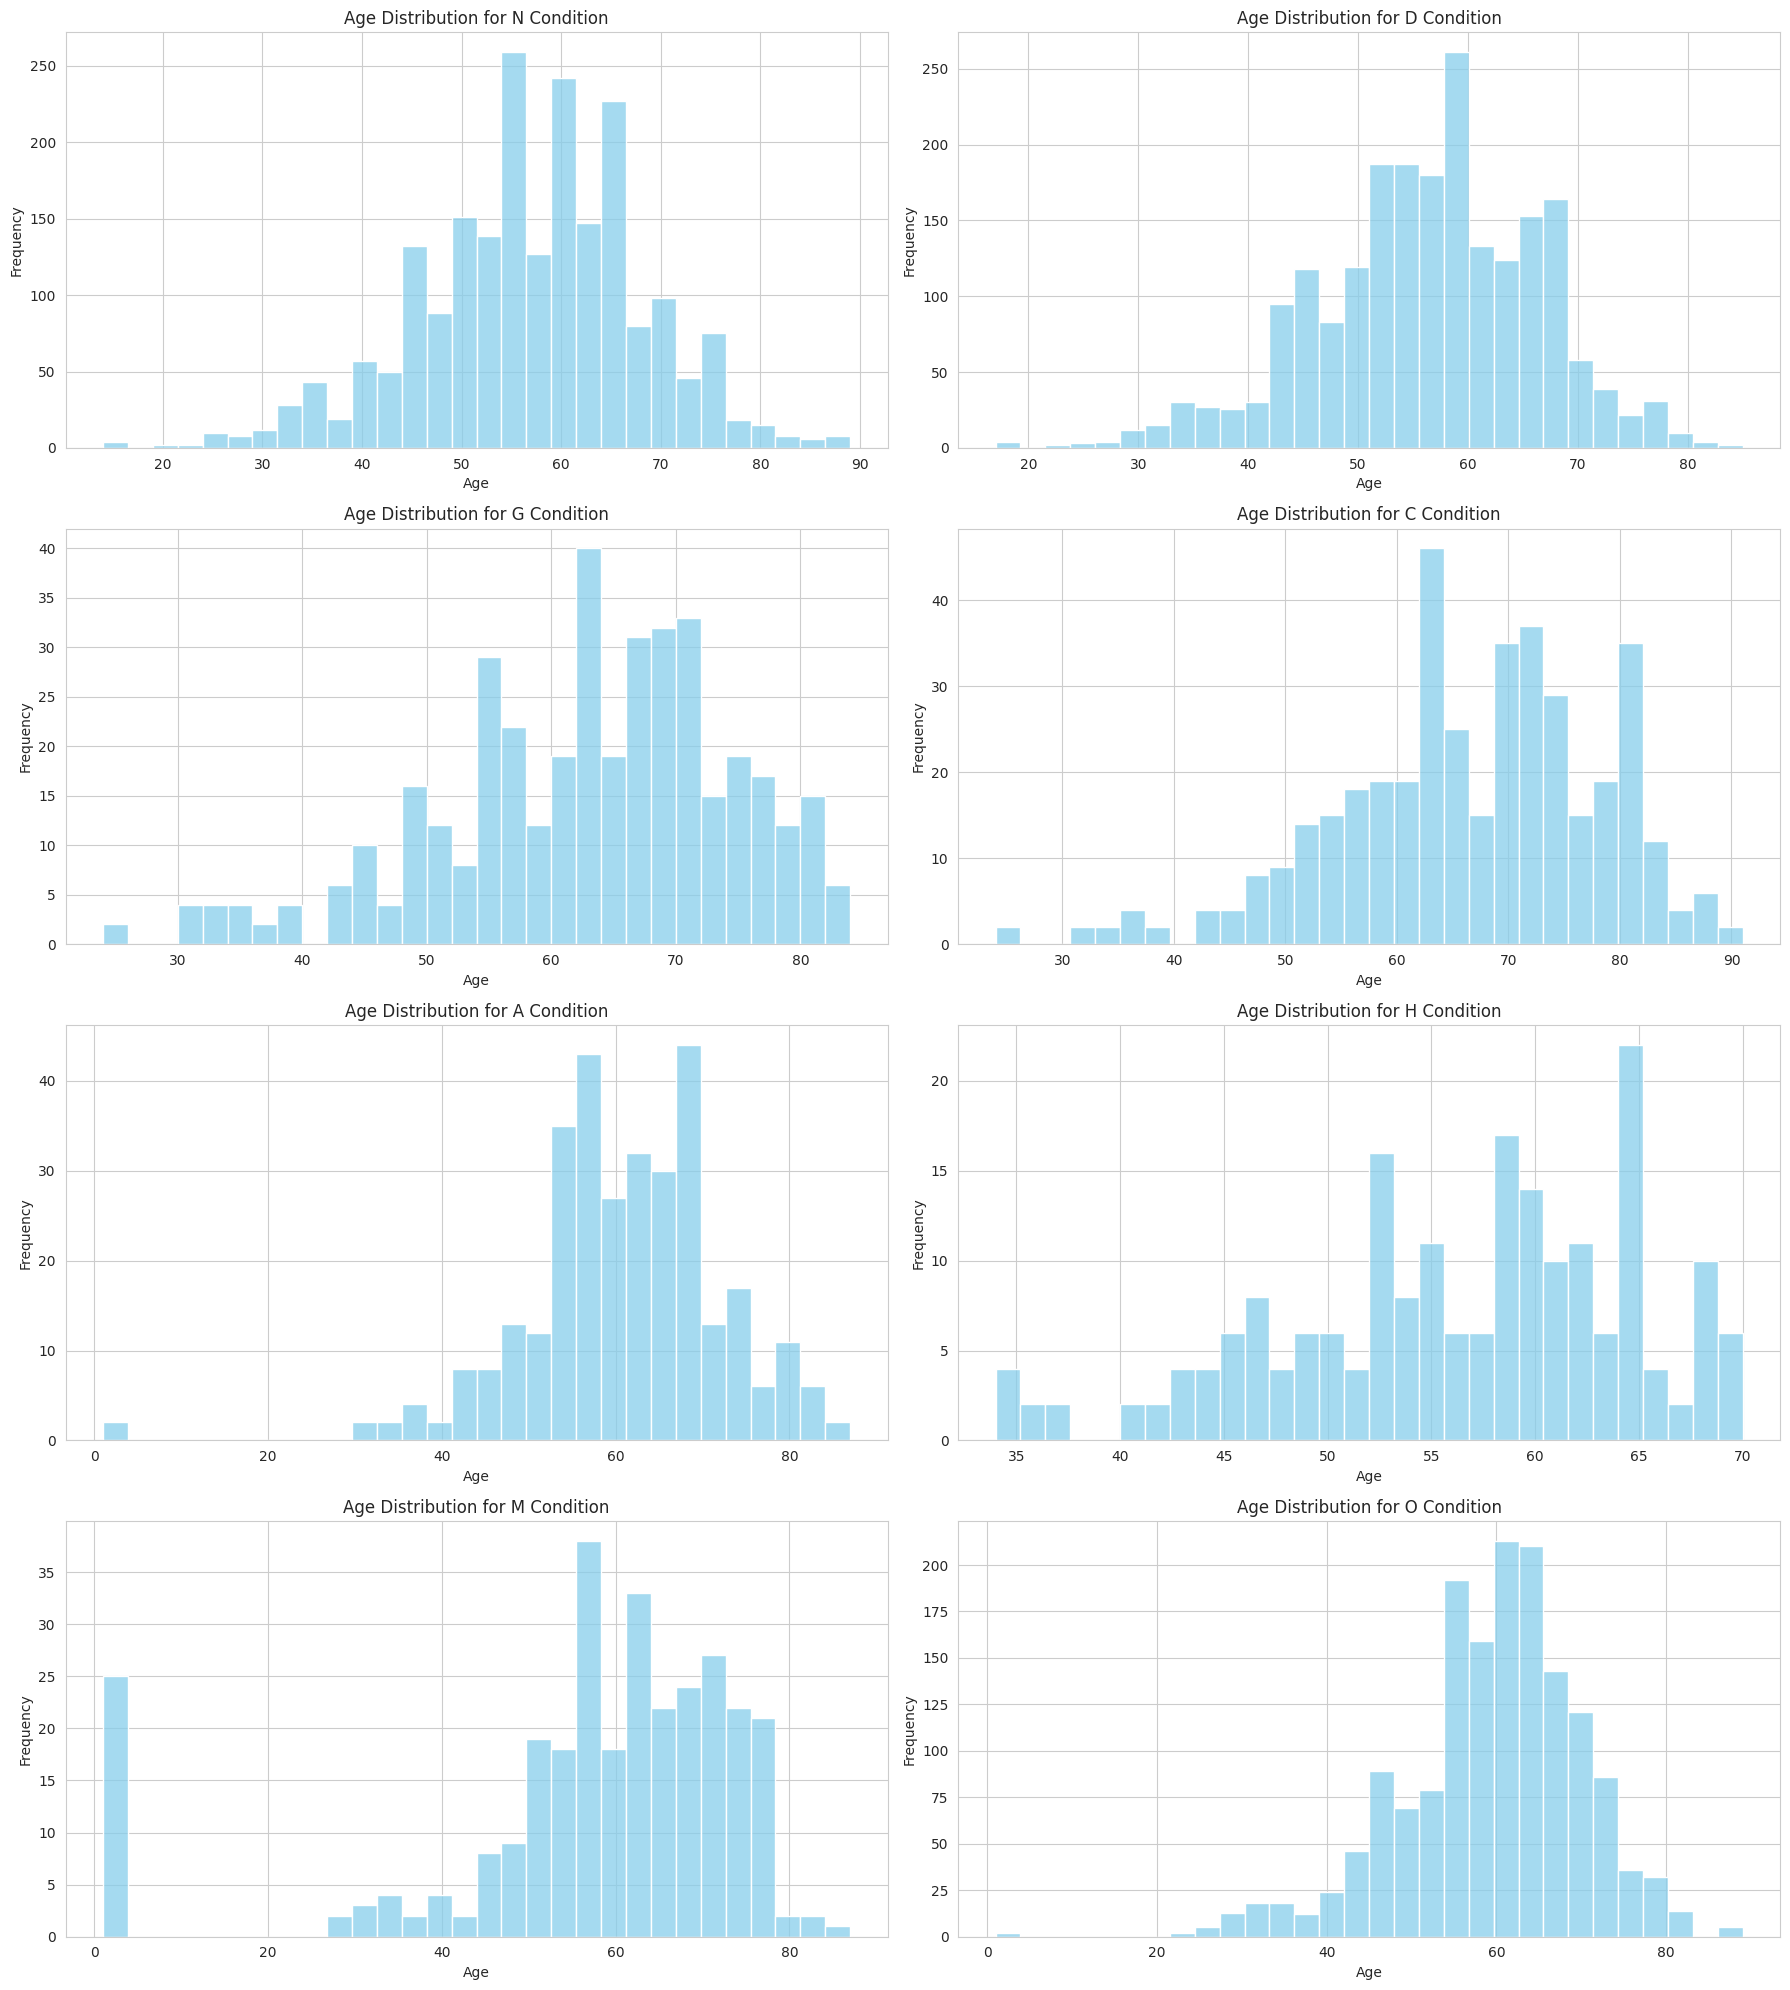

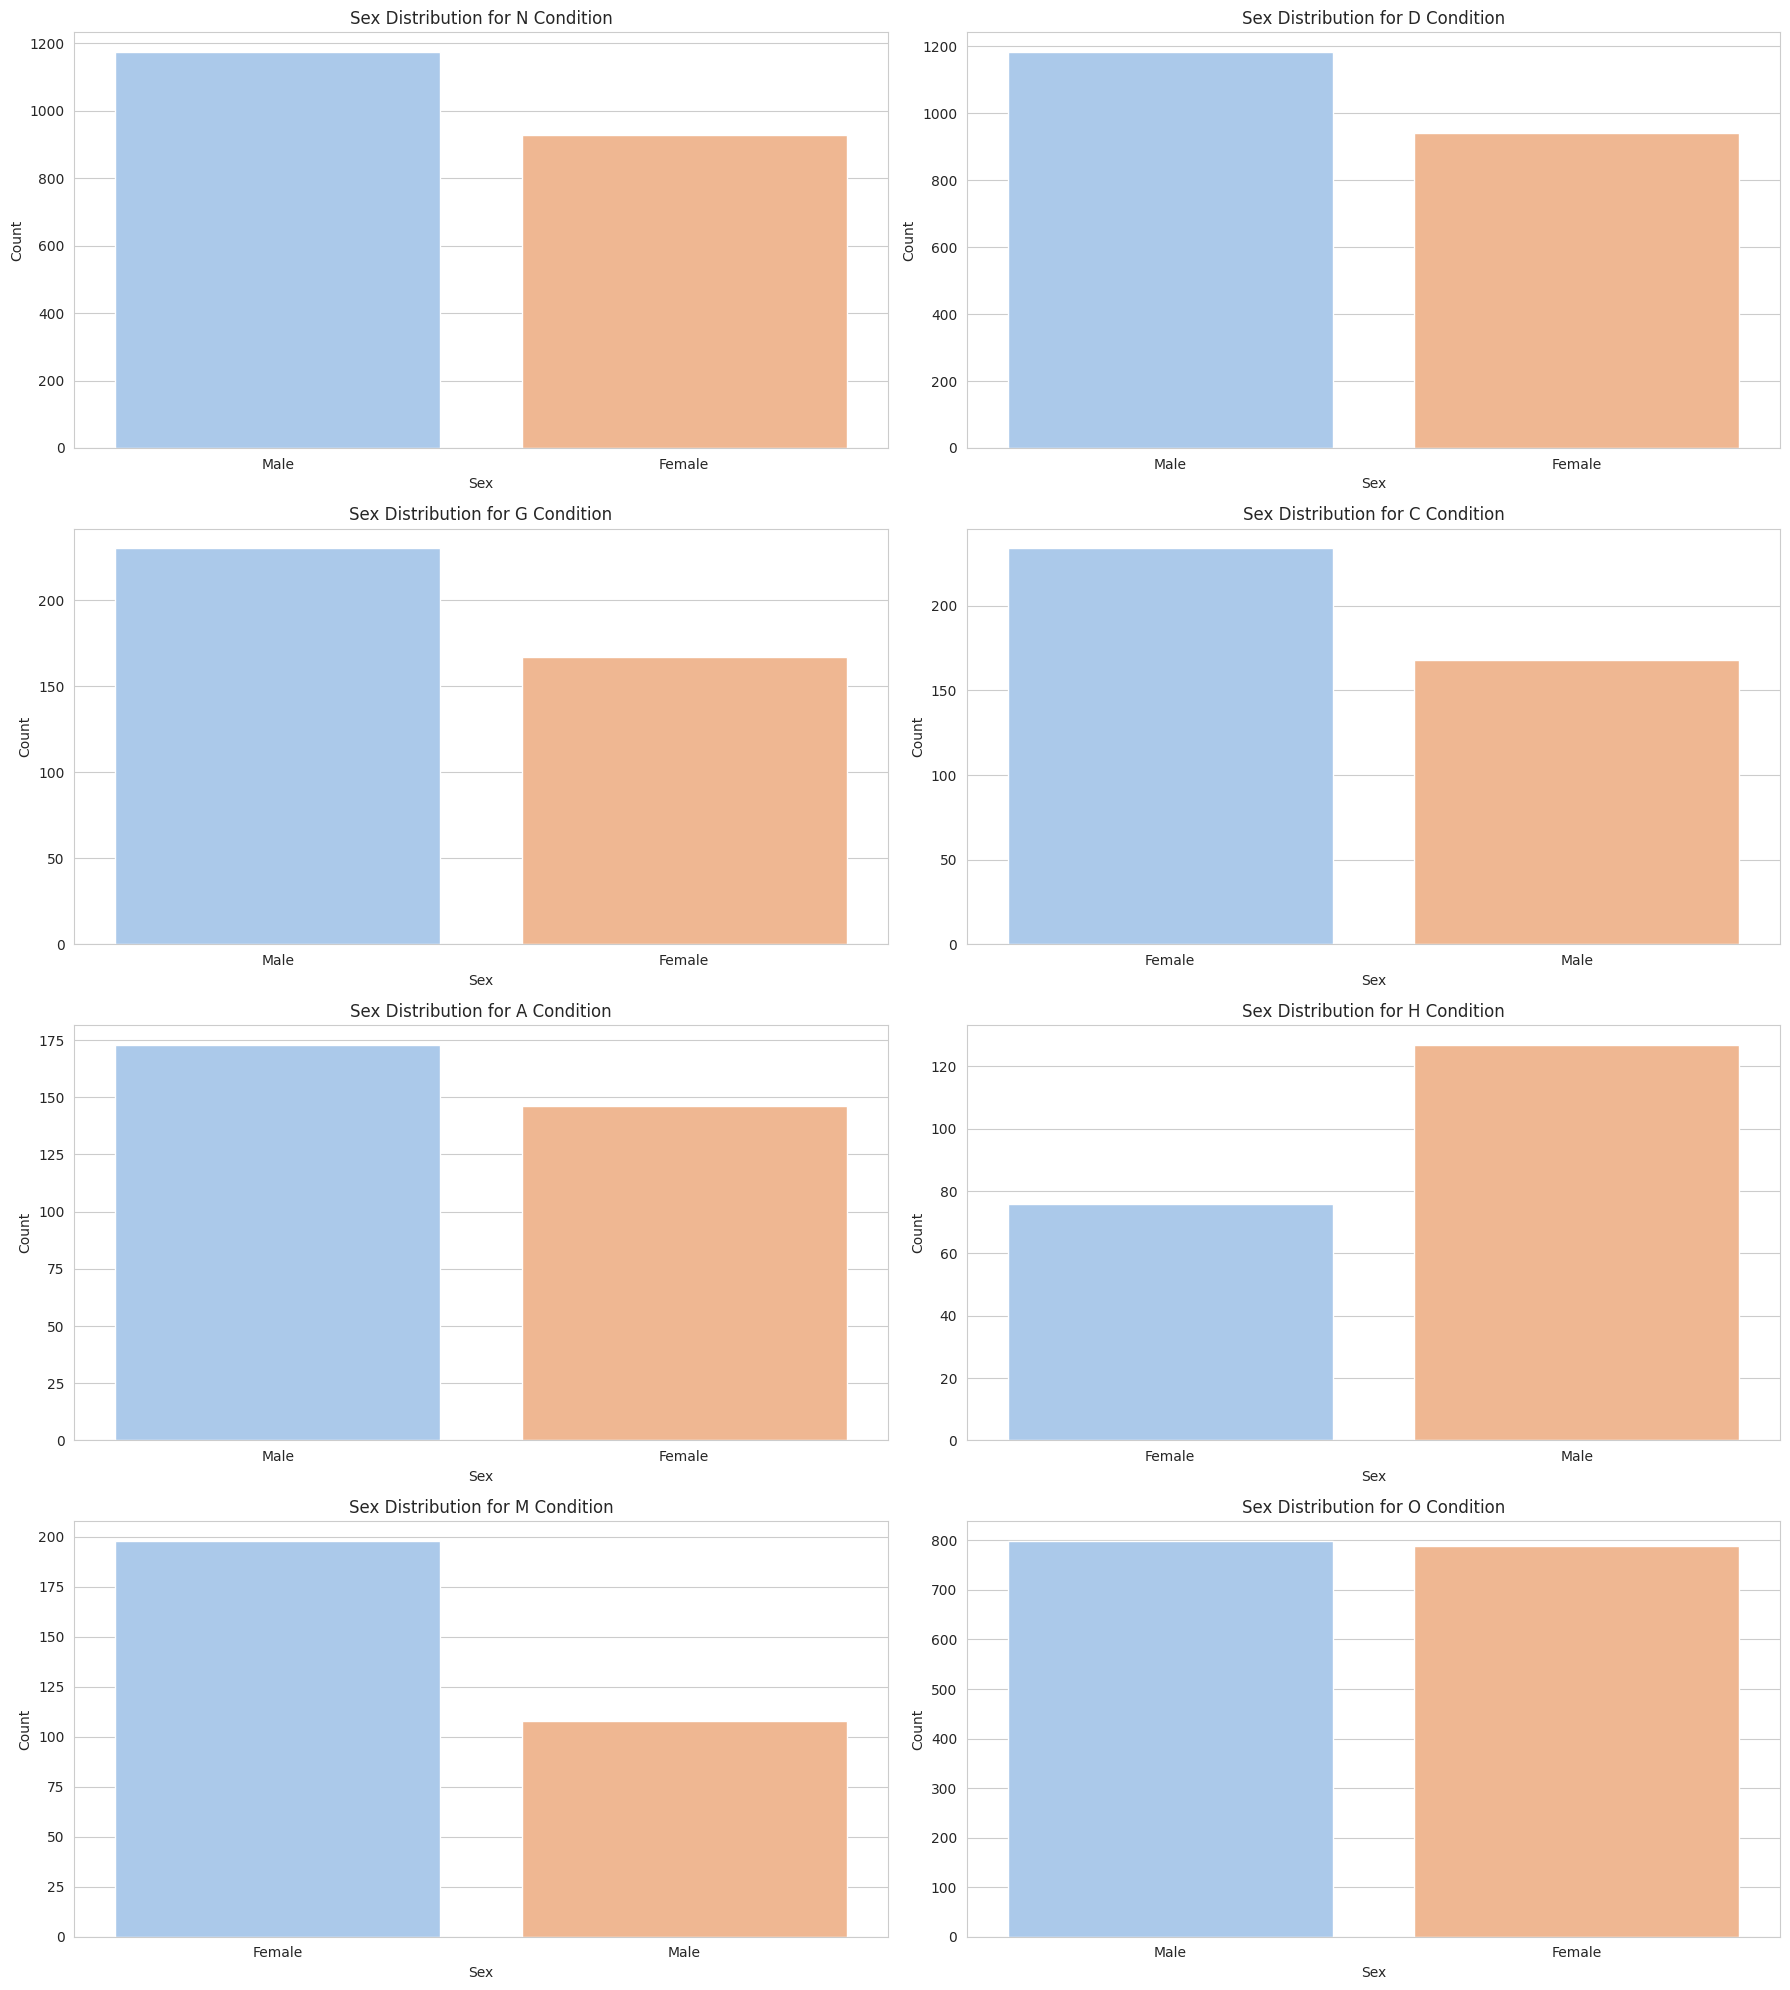

In [ ]:
# Extracting condition columns
conditions = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']  # These are the binary condition columns in the dataset

# Create a figure for the distribution of age per condition
fig, axes = plt.subplots(4, 2, figsize=(18, 20))  # Adjust the size and layout as needed

# Plotting age distribution for each condition
for i, condition in enumerate(conditions):
    # Find the rows where each condition is present
    condition_data = df_data[df_data[condition] == 1]

    # Plotting a histogram of patient ages for each condition
    sns.histplot(condition_data['Patient Age'], bins=30, ax=axes[i // 2, i % 2], kde=False, color='skyblue')
    axes[i // 2, i % 2].set_title(f'Age Distribution for {condition} Condition')
    axes[i // 2, i % 2].set_xlabel('Age')
    axes[i // 2, i % 2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


# Create a figure for the distribution of sex per condition
fig, axes = plt.subplots(4, 2, figsize=(18, 20))  # Adjust the size and layout as needed

# Plotting sex distribution for each condition
for i, condition in enumerate(conditions):
    # Find the rows where each condition is present
    condition_data = df_data[df_data[condition] == 1]

    # Plotting a bar chart of patient sex for each condition
    sns.countplot(x='Patient Sex', hue='Patient Sex', data=condition_data, ax=axes[i // 2, i % 2], palette='pastel', dodge=False)
    axes[i // 2, i % 2].set_title(f'Sex Distribution for {condition} Condition')
    axes[i // 2, i % 2].set_xlabel('Sex')
    axes[i // 2, i % 2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


# Left and Right Images per Diagnosis Displayed

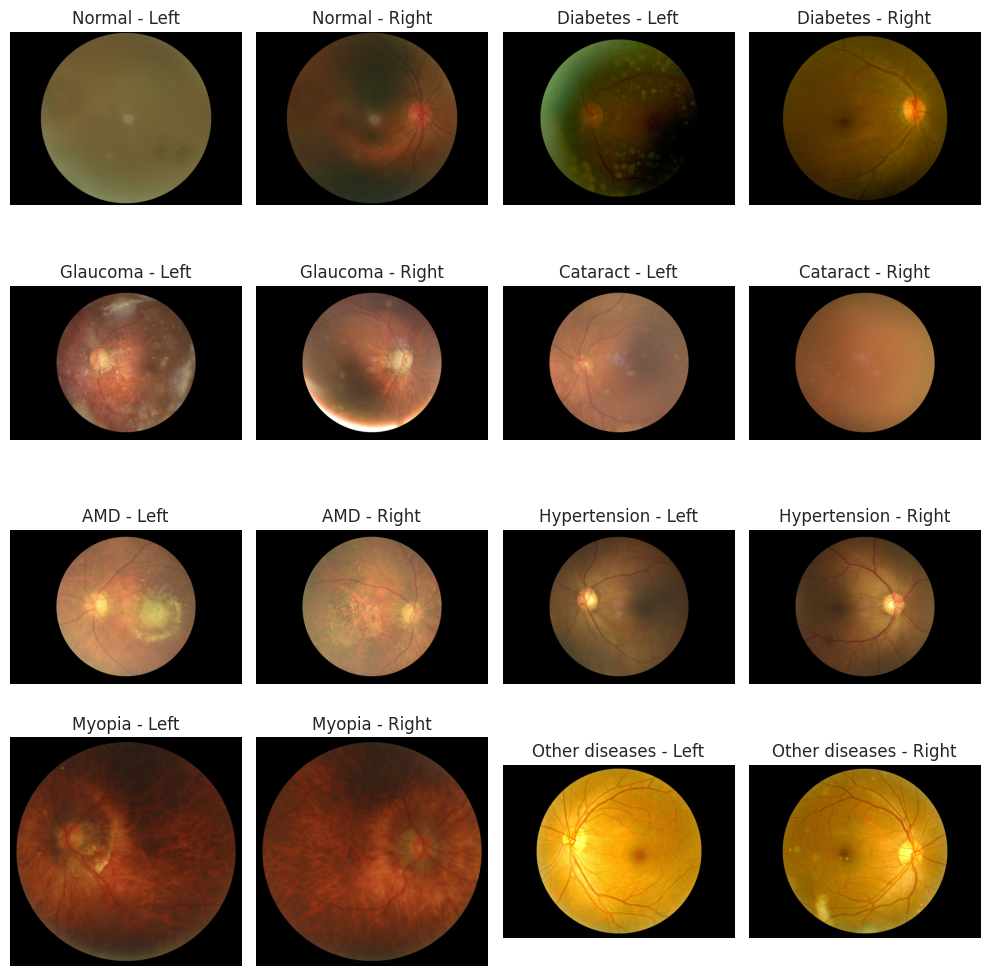

In [ ]:
# Function to decode one-hot encoded labels to class names
def decode_labels(target, class_labels):
    index = ast.literal_eval(target).index(1)
    return class_labels[index]

df_data['class_name'] = df_data['target'].apply(lambda x: decode_labels(x, class_labels))

# Function to check if the file exists
def file_exists(file_path):
    return os.path.exists(file_path)

# Function to load and preprocess images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image
    return image
    plt.show()

def display_images_grid_for_all_classes(df, class_labels, images_dir):
    # plot with 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(10,10))

    # Iterate over the classes and their respective positions in the grid
    for i, class_label in enumerate(class_labels):
        class_df = df[df['class_name'] == class_label]


        if len(class_df) < 1:
            print(f"Not enough images for class {class_label}. Needed 1, found {len(class_df)}")
            continue


        row = class_df.iloc[0]

        # Assuming you have a function that correctly fetches the image from your file system
        left_image = load_image(os.path.join(images_dir, row['Left-Fundus']))
        right_image = load_image(os.path.join(images_dir, row['Right-Fundus']))

        # Compute grid indices
        grid_row = i // 2
        grid_col = (i % 2) * 2  # Multiply by 2 because each class takes 2 columns

        # Display the images on the grid
        axes[grid_row, grid_col].imshow(left_image)
        axes[grid_row, grid_col].set_title(f'{class_label} - Left')
        axes[grid_row, grid_col].axis('off')

        axes[grid_row, grid_col + 1].imshow(right_image)
        axes[grid_row, grid_col + 1].set_title(f'{class_label} - Right')
        axes[grid_row, grid_col + 1].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, 4 * 2, 2):
        grid_row = j // 2
        grid_col = (j % 2) * 2
        axes[grid_row, grid_col].axis('off')
        axes[grid_row, grid_col + 1].axis('off')

    plt.tight_layout()
    plt.show()
# Assuming the images directory is set correctly to where the images are located
images_dir = 'ODIR-5K/ODIR-5K/Training Images/'

display_images_grid_for_all_classes(df_data, class_labels, images_dir)